In [22]:
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPRegressor
from dmba import classificationSummary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import util
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from dmba import regressionSummary
import seaborn as sns

In [2]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 81)

In [3]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)
#feature = pd.read_csv('Data/Created Datasets/KSI_Feature_Collapse.csv', index_acol = 0)
#count = pd.read_csv('Data/Created Datasets/KSI_Collapse_Count_truncate3.csv')

In [6]:
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)

In [7]:
ultimate_df = ultimate_df.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [8]:
ultimate_df['TIME'] = round(ultimate_df['TIME']/100,3)
#ultimate_df.head()

In [25]:
ultimate_df.columns

Index(['IncidentsTotal', 'SeverityScore', 'PercentOfVehicles',
       'AvgAcceleration', 'LATITUDE', 'LONGITUDE', 'COUNT', 'INVAGE',
       'RDSFCOND', 'VISIBILITY', 'LIGHT', 'TRAFFCTL', 'DRIVACT', 'DRIVCOND',
       'VEHTYPE', 'TIME'],
      dtype='object')

In [26]:
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude',  'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV', 'PercentOther', 'IncidentsTotal', 'VEHTYPE', 'TIME')]]

X = pd.get_dummies(X, drop_first = True)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

In [27]:
Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [38]:
model = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(3,),activation='logistic', max_iter= 10000,learning_rate='invscaling',random_state=1)
)

model.fit(train_X, train_Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', hidden_layer_sizes=(3,),
                              learning_rate='invscaling', max_iter=10000,
                              random_state=1))])

In [39]:
print(regressionSummary(train_Y, model.predict(train_X)))
regressionSummary(valid_Y, model.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0239
       Root Mean Squared Error (RMSE) : 1.6812
            Mean Absolute Error (MAE) : 1.2926
          Mean Percentage Error (MPE) : -39.7265
Mean Absolute Percentage Error (MAPE) : 63.5231
None

Regression statistics

                      Mean Error (ME) : 0.0589
       Root Mean Squared Error (RMSE) : 1.9315
            Mean Absolute Error (MAE) : 1.4681
          Mean Percentage Error (MPE) : -44.7654
Mean Absolute Percentage Error (MAPE) : 73.0960


<AxesSubplot:xlabel='COUNT'>

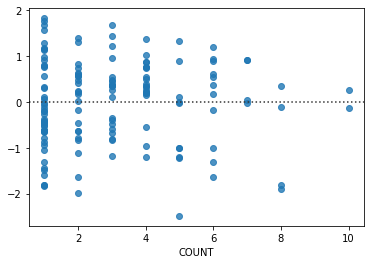

In [40]:
sns.residplot(y = model.predict(valid_X), x = valid_Y)

In [31]:
explainer = shap.KernelExplainer(model.predict, train_X)
shap_values = explainer.shap_values(valid_X ,nsamples=100)

X does not have valid feature names, but StandardScaler was fitted with feature names
Using 564 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/142 [00:00<?, ?it/s]X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}

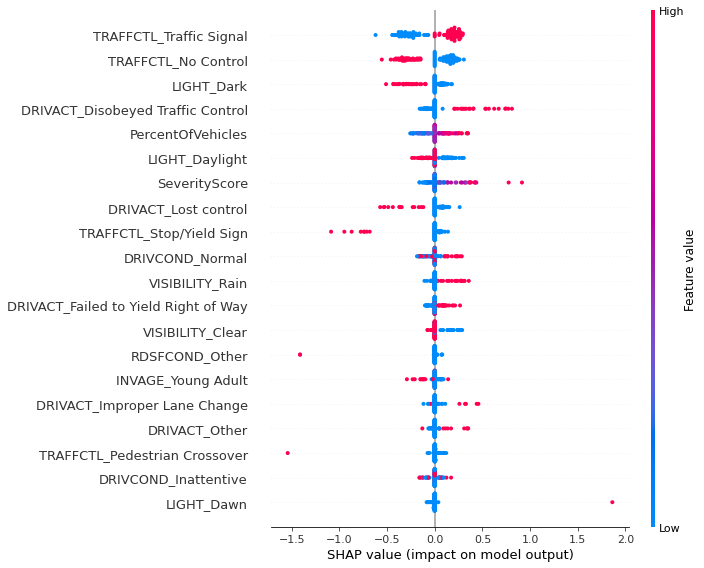

In [32]:
shap.summary_plot(shap_values, valid_X, feature_names= X.columns)